In [91]:
import json
import math

import time
import numpy as np

from scipy import interpolate
from scipy.interpolate import interpolate

from matplotlib import pyplot as plt

$\textbf{Plant}$

This class which provides an interface to manage the binning of a trajectory of states and control inputs to obtain the conditional pmf $f(x_k|x_{k-1}, u_k)$ of the plant.

In [92]:
class Plant:

    def __init__(self, x_max, x_min, u_max, u_min, x_discr, u_discr):
        # Bounds for u and x
        self.x_max = x_max
        self.x_min = x_min
        self.u_max = u_max
        self.u_min = u_min

        # Amount of bins (resolution) for u and x
        self.x_discr = x_discr
        self.u_discr = u_discr

        # Discretization step for x and u
        self.x_step = (self.x_max - self.x_min)/self.x_discr
        self.u_step = (self.u_max - self.u_min)/self.u_discr
    
        self.x_axis = [self.x_min + (i+0.5)*self.x_step for i in range(self.x_discr)]
        self.u_axis = [self.u_min + (j+0.5)*self.u_step for j in range(self.u_discr)]  

        self.full_joint = np.zeros((self.x_discr, self.u_discr, self.x_discr)) #Initializing f(x_k, u_k, x_{k-1}) (3D array)
        self.reduced_joint = np.zeros((self.x_discr, self.u_discr)) #Initializing f(u_k, x_{k-1}) (2D array)
        self.f_x = np.zeros((self.x_discr, self.u_discr, self.x_discr)) #Initializing f(x_k| u_k, x_{k-1}) (3D array)

    def getXdiscr(self):
        return self.x_discr

    def getUdiscr(self):
        return self.u_discr

    def getXmin(self):
        return self.x_min

    def getUmin(self):
        return self.u_min

    def getXmax(self):
        return self.x_max

    def getUmax(self):
        return self.u_max

    def getXstep(self):
        return self.x_step

    def getUstep(self):
        return self.u_step

    def getXaxis(self):
        return self.x_axis

    def getUaxis(self):
        return self.u_axis

    def getPlant(self, x, u):
        # Function that handles the binning of a trajectory
        # Given a history for the state and the input (ie two lists), browses each list and increments the appropriate histogram bins 
        for i in range(len(x)-1): #N-1 iterations (since we study consecutive pairs of states, one iteration less than the number of states)
            xkm1 = x[i] #x_{k-1}
            xk = x[i+1] #x_k
            uk = u[i+1] #u_k

            #Calculating the index from the min value and the discretization step
            indXkm1 = int((xkm1 - self.x_min)//self.x_step)
            indXk = int((xk - self.x_min)//self.x_step)
            indUk = int((uk - self.u_min)//self.u_step)
            self.full_joint[indXkm1][indUk][indXk] += 1 #Updating the full joint 'pmf'
            self.reduced_joint[indXkm1][indUk] += 1 #Updating the partial 'pmf'

        for i in range(self.x_discr): #For each x_{k-1}
            for j in range(self.u_discr): #For each u_k
                for k in range(self.x_discr): #For each x_k
                    if self.full_joint[i][j][k] == 0: #Failsafe to avoid dividing by zero
                        self.f_x[i][j][k] = 0 #If we've never encountered this state, let the conditionnal value be zero
                    else:
                        self.f_x[i][j][k] = self.full_joint[i][j][k]/self.reduced_joint[i][j] #Divide the full joint by the partial joint
   

$\textbf{GaussianPlant}$

This class extends the class Plant and provides an interface to get the conditional pmf of the plant, using the explicit formula of the Gaussian.

The $\textit{GaussianPlant}$ class has been used to obtain a Gaussian conditional pmf $f(x_k|x_{k-1}, u_k)$ of the plant, in the form of an entry of $[mean, std]$, usable in an algorithm of control from demonstration that employes analytical computational techniques, implemented in the $\textit{AnalyticalSolver}$ class, or in the form of a normal Gaussian distribution that can be used in a control from demonstration algorithm that uses numerical computational techniques.

In [93]:
class GaussianPlant(Plant):

    def __init__(self, x_max, x_min, u_max, u_min, x_discr, u_discr, a, b, sigma, mode="analytic"):
        super().__init__(x_max, x_min, u_max, u_min, x_discr, u_discr)
        self.sigma = sigma
        self.a = a
        self.b = b
        self.mode = mode
        

    def getPlant(self, x = None, y = None):
        # Function for getting the plant (f_x or g_x) from the parameters.
        # The arguments are the linear parameters for the mean and the std.
        # The Gaussians are simply coded as [mean, std] to simplify calculations
        if self.mode == "analytic":
            self.f_x = np.zeros((self.x_discr, self.u_discr, 2)) # Initializing the empty array
        for i in range(self.x_discr): # Iterating over the state space for x_{k-1}
            x_km1 = self.x_min + (i+0.5)*self.x_step # Calculating x_{k-1}
            for j in range(self.u_discr): # Iterating over the action space for u_k
                u_k = self.u_min + (j+0.5)*self.u_step # Calculating u_k
                mu = self.a*x_km1 + self.b*u_k # Calculating the average of the Gaussian
                if self.mode == "analytic":
                    self.f_x[i][j] = [mu, self.sigma] # Adding the Gaussian in [mean, std] form to the array
                else:
                    self.f_x[i][j] = self.sample_gaussian(mu, self.sigma, self.x_axis)
        return(self.f_x)

    def sample_gaussian(self, mu, sigma, Ax):
        # Where Ax is the horizontal axis
        pmf = [0]*len(Ax) # Initializing the pmf
        for i in range(len(Ax)): # Iterating over the state space to calculate the elements of the pmf
            pmf[i] = np.exp(-0.5*((Ax[i]-mu)/sigma)**2)  # Using the explicit formula for the Gaussian
                                                         # The multiplicative factor is omitted as the pmf will be normalized
        S = np.sum(pmf) # Calculating the sum for normalization
        return([x/S for x in pmf])

$\textbf{NumericalSolver}$

This class provides an interface for carrying out control from demonstration using numerical computational techniques and it is capable of receiving any type of probability distribution as input.

In [94]:
class NumericalSolver:

    def __init__(self, f, g, g_u):
        self.f = f # Plant object of the agent
        self.g = g # Plant object of the demonstrator
        self.g_u = g_u # TargetPolicy object


    def DKL(self, f, g):
        # Kullback-Leibler divergence between two arrays, they have to be pmfs (ie histograms that sum to 1)
        return(np.sum([f[i]*math.log(f[i]/g[i]) for i in range(len(f)) if f[i]!=0 and g[i]!= 0]))

    def runFPD(self, xStart, tHor=0):

        x_discr = self.f.getXdiscr()
        u_discr = self.f.getUdiscr()

        f_x = self.f.getPlant()
        g_x = self.g.getPlant()

        # Runs the control from demos algorithm, assuming the agent is at state xStart (given as an index!) with a time horizon tHor
        # Initializing zero gamma function
        gamma = np.zeros(x_discr)
        # If time horizon is greater than 0 we consider the states from the min between (xStart + time horizon -1) and 
        # (d_discr-2) (in order to not exceed the dimension of the array) to (xStart + 1)
        if tHor > 0: 
            stateAtTime = list(range(min(xStart + tHor-1, x_discr - 2), xStart, -1))
        # Else we don't take into account the future states, but we consider only the next time step
        else: 
            stateAtTime = [] 
        
        # We calculate gamma from xStart + time horizon to xStart + 1
        for xk, uk in zip(stateAtTime, stateAtTime):
            # We initialize an auxiliary array, which we will use to calculate gamma_k(x_k)
            gammaArray = np.zeros(u_discr)
            # We get f(x_{k+1}|x_k,u_{k+1})
            plant = f_x[xk][uk+1] 
            # We get g(x_{k+1}|x_k,u_{k+1})
            target_plant = g_x[xk][uk+1]
            # We build the array with the exp of the numeric DKL of the 'future' plants
            gammaArray[uk+1] = np.exp(-self.DKL(plant, target_plant))
            # Finally we calculate gamma, which is the log of the expectation of our auxiliary array
            gamma[xk] = np.log(np.dot(self.g_u.target_policy(xk),gammaArray)) 
        
        # Previous state x_(k-1)
        xkm1 = xStart  
        policy = np.zeros(u_discr)
        # We extract the corresponding target policy, g(u_k|x_{k-1}) 
        target_pol = self.g_u.target_policy(xkm1) 
        for u in range(u_discr): 
            # We get f(x_{k}|x_{k - 1}, u_k)
            plant = f_x[xkm1][u]
            # We get g(x_{k}|x_{k - 1}, u_k)
            target_plant = g_x[xkm1][u]
            # We sample plant for expectations
            policy[u] = target_pol[u]*np.exp(-self.DKL(plant, target_plant) + np.dot(plant,gamma))
        # We calculate the integral
        S = np.sum(policy)
        # We return the normalized result
        return([elt/S for elt in policy]) 

    def closedLoop(self, tHor=0):

        position = []
        speed = []
        x = 0

        x_discr = self.f.getXdiscr()
        u_discr = self.f.getUdiscr()

        x_step = self.f.getXstep()
        u_step = self.f.getUstep()

        u_min = self.f.getUmin()
        x_min = self.f.getXmin()

        f_x = self.f.getPlant()

        while(x < (x_discr*800)/1500):
            policy = self.runFPD(x, tHor) # We get the optimal policy
            u = np.random.choice(range(u_discr), p=policy) # We choose a random index u from the policy according to the distribution of the policy
            plant = f_x[x][u] # We get the conditional pmf of x_k: f(x_k|x_{k-1}, u_k)
            # We get the new state from the plant
            x = np.random.choice(range(x_discr), p=plant)
            x = max(x, 0)

            # We compute the value of state from the state index
            trueX = x_min + x_step*x

            # We compute the value of input from the input index
            trueU = u_min + u_step*u
            
            position.append(trueX)
            speed.append(trueU)

            print("Speed: " + str(trueU) + " km/h")
            print("New position: " + str(trueX) + " m")
    
        plt.figure(figsize=(8, 6), dpi=80)
        plt.subplot(2,1,1)
        plt.title("Simulation of the closed loop")
        plt.ylabel(r'Position $(m)$', fontsize=12)
        plt.plot(position)
        
        plt.subplot(2,1,2)
        plt.xlabel(r'Time $(s)$', fontsize=12)
        plt.ylabel(r'Velocity $(km/h)$', fontsize=12)
        plt.plot(speed)
        plt.show()

$\textbf{AnalyticalSolver}$

This class provides an interface to perform the control from demonstration using analytic computing techniques, in particular using the explicit formula of the Gaussian.

The pmf of the agent and of the demonstrator have to be Gaussian distribution.

In [95]:
class AnalyticalSolver(NumericalSolver):

    def __init__(self, f, g, g_u):
        super().__init__(f, g, g_u)

    def DKL(self, f, g):
        mu1 = f[0] #Extracting means
        mu2 = g[0]
        sigma1 = f[1] #Extracting stds
        sigma2 = g[1]
        
        el1 = math.log(sigma1/sigma2) # Calculating the sub-elements of the formula
        el2 = sigma1*sigma1 + (mu1-mu2)*(mu1-mu2)
        el3 = 2*sigma2*sigma2
        
        return(el1 + el2/el3 - 0.5)

    def runFPD(self, xStart, tHor=0):

        x_discr = self.f.getXdiscr()
        u_discr = self.f.getUdiscr()

        f_x = self.f.getPlant()
        g_x = self.g.getPlant()

        #Runs the control from demos algorithm, assuming the agent is at state xStart (given as an index!) with a time horizon tHor
        #Initializing zero gamma function
        gamma = np.zeros(x_discr)
        # If time horizon is greater than 0 we consider the states from the min between (xStart + time horizon -1) and
        # (d_discr-2) (in order to not exceed the dimension of the array) to (xStart + 1)
        if tHor >0: 
            stateAtTime = list(range(min(xStart + tHor-1, x_discr - 2), xStart, -1))
        # Else we don't take into account the future states, but we consider only the next time step
        else: 
            stateAtTime = [] 
        
        # We calculate gamma from xStart + time horizon to xStart + 1
        for xk, uk in zip(stateAtTime, stateAtTime):
            # We initialize an auxiliary array, which we will use to calculate gamma_k(x_k)
            gammaArray = np.zeros(u_discr)
            # We get f(x_{k+1}|x_k,u_{k+1}) in [mean, std] form
            plant = f_x[xk][uk+1]
            # We get g(x_{k+1}|x_k,u_{k+1}) in [mean, std] form
            target_plant = g_x[xk][uk+1]
            # We build the array with the exp of the analytic DKL of the 'future' plants
            gammaArray[uk+1] = np.exp(-self.DKL(plant, target_plant))
            # Finally we calculate gamma, which is the log of the expectation of our auxiliary array
            gamma[xk] = np.log(np.dot(self.g_u.target_policy(xk),gammaArray)) 
        
        # Previous state x_(k-1)
        xkm1 = xStart  
        policy = np.zeros(u_discr)
        # We extract the corresponding target policy, g(u_k|x_{k-1})
        target_pol = self.g_u.target_policy(xkm1)
        for u in range(u_discr):
            # We get f(x_{k}|x_{k - 1}, u_k)
            plant = f_x[xkm1][u]
            # We get g(x_{k}|x_{k - 1}, u_k)
            target_plant = g_x[xkm1][u]
            # We sample plant for expectations
            policy[u] = target_pol[u]*np.exp(-self.DKL(plant, target_plant) + np.dot(self.f.sample_gaussian(plant[0],plant[1], self.f.getXaxis()), gamma))
        # We calculate the integral
        S = np.sum(policy)
        # We return the normalized result
        return([elt/S for elt in policy]) 

    def closedLoop(self, tHor=0):

        position = []
        speed = []
        x = 0

        x_discr = self.f.getXdiscr()
        u_discr = self.f.getUdiscr()

        x_step = self.f.getXstep()
        u_step = self.f.getUstep()

        u_min = self.f.getUmin()

        f_x = self.f.getPlant()

        while(x < (x_discr*800)/1500):
            policy = self.runFPD(x, tHor) # We get the optimal policy
            u = np.random.choice(range(u_discr), p=policy) # We choose a random index u from the policy according to the distribution of the policy
            plant = f_x[x][u] # We get the conditional pmf of x_k: f(x_k|x_{k-1}, u_k)
            # We get the new state from the plant
            trueX = np.random.normal(plant[0],plant[1])
            x = round(trueX/x_step)

            x = max(x, 0)

            # We compute the value of input from the input index
            trueU = u_min + u_step*u
            
            position.append(trueX)
            speed.append(trueU)

            print("Speed: " + str(trueU) + " km/h")
            print("New position: " + str(trueX) + " m")
    
        plt.figure(figsize=(8, 6), dpi=80)
        plt.subplot(2,1,1)
        plt.title("Simulation of the closed loop")
        plt.ylabel(r'Position $(m)$', fontsize=12)
        plt.plot(position)
        
        plt.subplot(2,1,2)
        plt.xlabel(r'Time $(s)$', fontsize=12)
        plt.ylabel(r'Velocity $(km/h)$', fontsize=12)
        plt.plot(speed)
        plt.show()

$\textbf{TargetPolicy}$

This class provides an interface to obtain the probability distribution of the control input given the previous state.

In [96]:
class TargetPolicy:

    def __init__(self, g, fmean, fstd):
        self.g = g
        self.g_u = [fmean(self.g.getXaxis()), fstd(self.g.getXaxis())]

    def target_policy(self, indx):
        return(self.g.sample_gaussian(self.g_u[0][indx], self.g_u[1][indx], self.g.getUaxis())) 

$\textbf{System parameters}$

In [97]:
#Bounds for u (velocity) and x (distance)
v_min = 15
v_max = 85

d_min = 0
d_max = 1500

#Amount of bins (resolution) for u and x
v_discr = 100
d_discr = 100

In [98]:
#Parameters for f(x_k|x_{k-1},u_k)
a_c = 0.982
b_c = 0.2591
sigma_c = 13.059

#Parameters for g(x_k|x_{k-1},u_k)
a_e = 0.9811
b_e = 0.2723
sigma_e = 8.811

$\textbf{Target policy}$

In [99]:
# Target policy
f1 = open('train_mean.json')
f2 = open('train_std.json')

means = json.load(f1)
std = json.load(f2)

# means["x"] and means["y"] are arrays of values used to approximate some function g(u_k|x_{k_1}). 
fmean = interpolate.interp1d(means['x'],means['y'], fill_value="extrapolate")
fstd = interpolate.interp1d(std['x'],std['y'], fill_value="extrapolate")

In [100]:
f = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_c, b_c, sigma_c, "analytic")
g = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_e, b_e, sigma_e, "analytic")
target_policy = TargetPolicy(g, fmean, fstd)

$\textbf{Closed loop simulation using analytic solver}$

Speed: 57.699999999999996 km/h
New position: 17.706845240029686 m
Speed: 54.9 km/h
New position: 18.82443651041211 m
Speed: 50.699999999999996 km/h
New position: 28.070221953667797 m
Speed: 55.599999999999994 km/h
New position: 33.089645151543756 m
Speed: 50.699999999999996 km/h
New position: 58.63018072120786 m
Speed: 55.599999999999994 km/h
New position: 83.29463617762018 m
Speed: 56.3 km/h
New position: 97.69023380932018 m
Speed: 52.099999999999994 km/h
New position: 120.38492036003964 m
Speed: 52.8 km/h
New position: 119.23810335831936 m
Speed: 59.8 km/h
New position: 139.96463219854266 m
Speed: 58.4 km/h
New position: 149.71551105159526 m
Speed: 58.4 km/h
New position: 194.95756585194923 m
Speed: 57.699999999999996 km/h
New position: 216.5176908926681 m
Speed: 50.0 km/h
New position: 248.09555947199715 m
Speed: 50.0 km/h
New position: 274.78531102431464 m
Speed: 52.099999999999994 km/h
New position: 290.15292019933776 m
Speed: 51.4 km/h
New position: 305.22137337028624 m
Speed: 54

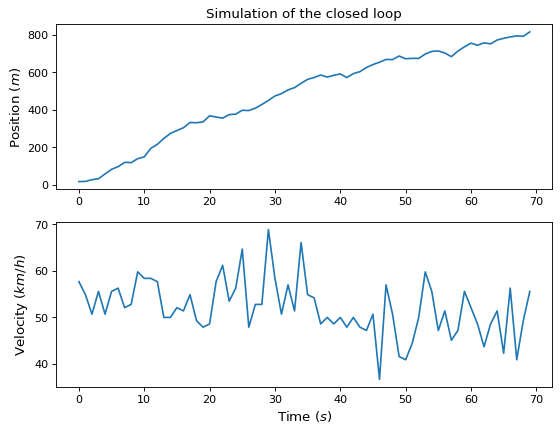

In [101]:
solver = AnalyticalSolver(f, g, target_policy)
solver.closedLoop()

$\textbf{Closed loop simulation using numeric solver}$

In [102]:
f = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_c, b_c, sigma_c, "numeric")
g = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_e, b_e, sigma_e, "numeric")
target_policy = TargetPolicy(g, fmean, fstd)

Speed: 54.199999999999996 km/h
New position: 15.0 m
Speed: 58.4 km/h
New position: 30.0 m
Speed: 50.699999999999996 km/h
New position: 15.0 m
Speed: 52.8 km/h
New position: 15.0 m
Speed: 60.5 km/h
New position: 60.0 m
Speed: 50.0 km/h
New position: 75.0 m
Speed: 49.3 km/h
New position: 90.0 m
Speed: 57.699999999999996 km/h
New position: 105.0 m
Speed: 60.5 km/h
New position: 90.0 m
Speed: 46.5 km/h
New position: 105.0 m
Speed: 43.7 km/h
New position: 90.0 m
Speed: 50.0 km/h
New position: 105.0 m
Speed: 51.4 km/h
New position: 90.0 m
Speed: 68.19999999999999 km/h
New position: 105.0 m
Speed: 59.8 km/h
New position: 90.0 m
Speed: 53.5 km/h
New position: 90.0 m
Speed: 52.8 km/h
New position: 105.0 m
Speed: 64.0 km/h
New position: 120.0 m
Speed: 50.699999999999996 km/h
New position: 120.0 m
Speed: 59.099999999999994 km/h
New position: 120.0 m
Speed: 54.199999999999996 km/h
New position: 165.0 m
Speed: 59.099999999999994 km/h
New position: 165.0 m
Speed: 54.9 km/h
New position: 165.0 m
Spee

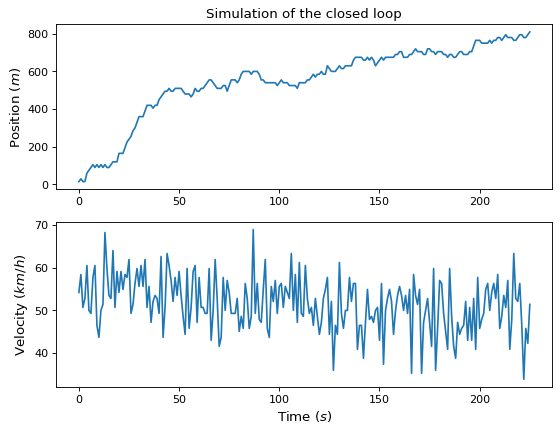

In [103]:
solver = NumericalSolver(f, g, target_policy)
solver.closedLoop()

$\textbf{Comparing then elapsed time as d\_discr varies}$

Speed: 65.4 km/h
New position: 23.83791459111608 m
Speed: 54.199999999999996 km/h
New position: 31.110389225428925 m
Speed: 52.099999999999994 km/h
New position: 33.938559385265435 m
Speed: 54.199999999999996 km/h
New position: 60.262463341579576 m
Speed: 62.599999999999994 km/h
New position: 65.91441299014654 m
Speed: 60.5 km/h
New position: 71.09326094480332 m
Speed: 57.0 km/h
New position: 106.23992551974774 m
Speed: 45.8 km/h
New position: 129.44904496936414 m
Speed: 66.8 km/h
New position: 171.02422603607616 m
Speed: 59.099999999999994 km/h
New position: 170.62741593814104 m
Speed: 65.4 km/h
New position: 169.32597525607036 m
Speed: 50.0 km/h
New position: 159.74897293137127 m
Speed: 64.0 km/h
New position: 190.267478932567 m
Speed: 66.8 km/h
New position: 234.09626987864422 m
Speed: 41.599999999999994 km/h
New position: 255.65611584934925 m
Speed: 55.599999999999994 km/h
New position: 271.5742172056843 m
Speed: 46.5 km/h
New position: 265.32466895844834 m
Speed: 54.19999999999999

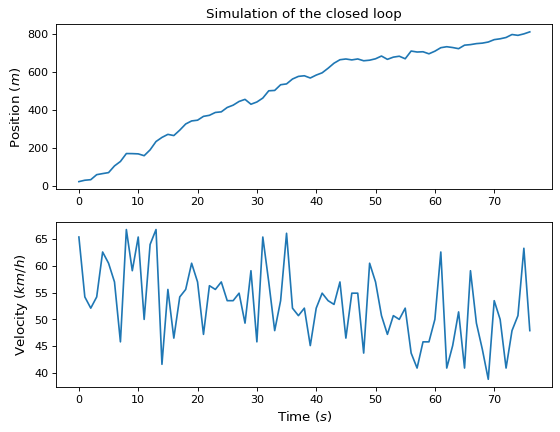

Speed: 65.75 km/h
New position: 19.415846079192562 m
Speed: 48.25 km/h
New position: 37.4675435787217 m
Speed: 59.099999999999994 km/h
New position: 51.19721376726723 m
Speed: 54.9 km/h
New position: 71.34425349245032 m
Speed: 54.199999999999996 km/h
New position: 88.28195082998262 m
Speed: 56.65 km/h
New position: 118.8166006317978 m
Speed: 52.099999999999994 km/h
New position: 121.73475884134112 m
Speed: 58.05 km/h
New position: 138.5873638529112 m
Speed: 44.05 km/h
New position: 169.13652351938063 m
Speed: 48.949999999999996 km/h
New position: 192.64528411812614 m
Speed: 57.349999999999994 km/h
New position: 204.41840150635954 m
Speed: 69.6 km/h
New position: 221.96419260468565 m
Speed: 59.449999999999996 km/h
New position: 235.1090482773781 m
Speed: 54.55 km/h
New position: 228.02614853722142 m
Speed: 57.699999999999996 km/h
New position: 227.21589351889415 m
Speed: 64.35 km/h
New position: 270.52202576659107 m
Speed: 63.3 km/h
New position: 282.51301398653317 m
Speed: 60.849999999

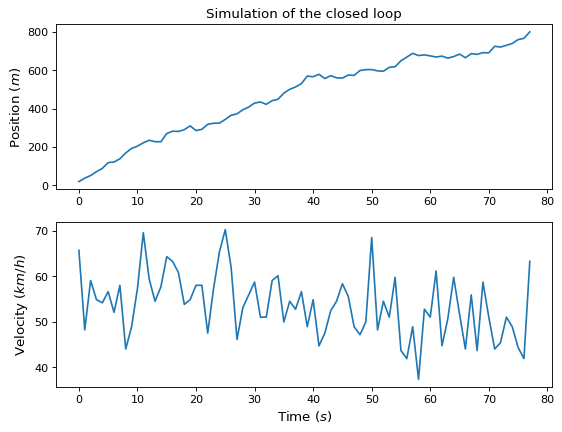

Speed: 59.8 km/h
New position: 49.76854313115719 m
Speed: 64.23333333333333 km/h
New position: 72.3963860274286 m
Speed: 58.86666666666667 km/h
New position: 81.50558688563132 m
Speed: 64.93333333333334 km/h
New position: 120.25436004454144 m
Speed: 65.63333333333333 km/h
New position: 173.032519492305 m
Speed: 53.96666666666667 km/h
New position: 180.35562202371457 m
Speed: 58.86666666666667 km/h
New position: 192.572420169874 m
Speed: 61.2 km/h
New position: 214.72452995242267 m
Speed: 51.86666666666667 km/h
New position: 219.4131940135823 m
Speed: 53.96666666666667 km/h
New position: 218.3923871402906 m
Speed: 65.63333333333333 km/h
New position: 242.32784347989983 m
Speed: 64.93333333333334 km/h
New position: 264.876315538163 m
Speed: 65.4 km/h
New position: 294.4857067848149 m
Speed: 57.93333333333334 km/h
New position: 302.49280154509404 m
Speed: 54.666666666666664 km/h
New position: 302.1126908178922 m
Speed: 59.333333333333336 km/h
New position: 311.8030055524679 m
Speed: 47.9 

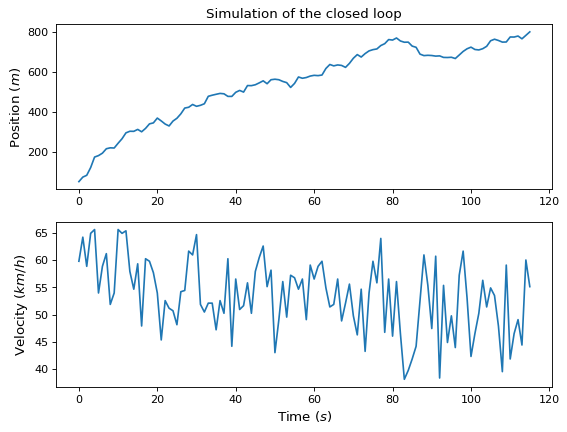

Speed: 57.875 km/h
New position: 29.35130449133395 m
Speed: 59.625 km/h
New position: 79.02082941478835 m
Speed: 48.074999999999996 km/h
New position: 86.7706708116593 m
Speed: 56.125 km/h
New position: 98.36322624389626 m
Speed: 52.974999999999994 km/h
New position: 125.68621015804857 m
Speed: 61.55 km/h
New position: 149.40753006037437 m
Speed: 66.8 km/h
New position: 193.4768013457151 m
Speed: 49.824999999999996 km/h
New position: 207.33040726111224 m
Speed: 43.0 km/h
New position: 216.1835216991333 m
Speed: 46.15 km/h
New position: 221.67372629595314 m
Speed: 63.824999999999996 km/h
New position: 237.77232975003713 m
Speed: 57.175 km/h
New position: 246.4883119576537 m
Speed: 53.5 km/h
New position: 260.85197644772717 m
Speed: 69.775 km/h
New position: 270.9272123046833 m
Speed: 59.974999999999994 km/h
New position: 290.79967885250346 m
Speed: 52.974999999999994 km/h
New position: 316.0303338353405 m
Speed: 52.974999999999994 km/h
New position: 319.1311805165425 m
Speed: 52.4499999

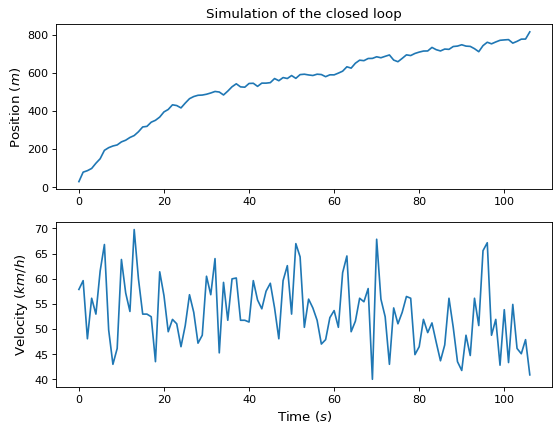

Speed: 59.52 km/h
New position: 17.800796956083442 m
Speed: 62.040000000000006 km/h
New position: 54.68602220174016 m
Speed: 63.300000000000004 km/h
New position: 84.81809031618916 m
Speed: 47.34 km/h
New position: 92.2636230134141 m
Speed: 63.300000000000004 km/h
New position: 112.30901024487675 m
Speed: 66.24000000000001 km/h
New position: 116.77641075149214 m
Speed: 63.300000000000004 km/h
New position: 149.17110657018182 m
Speed: 68.34 km/h
New position: 154.28400102882264 m
Speed: 44.120000000000005 km/h
New position: 157.6712633584283 m
Speed: 58.68000000000001 km/h
New position: 168.10050779744455 m
Speed: 67.36000000000001 km/h
New position: 181.60567808937375 m
Speed: 60.50000000000001 km/h
New position: 199.5282317857768 m
Speed: 50.28 km/h
New position: 233.910048511452 m
Speed: 46.64 km/h
New position: 236.70030192733697 m
Speed: 61.06 km/h
New position: 244.07943707581654 m
Speed: 57.980000000000004 km/h
New position: 253.4575544333623 m
Speed: 63.160000000000004 km/h
New 

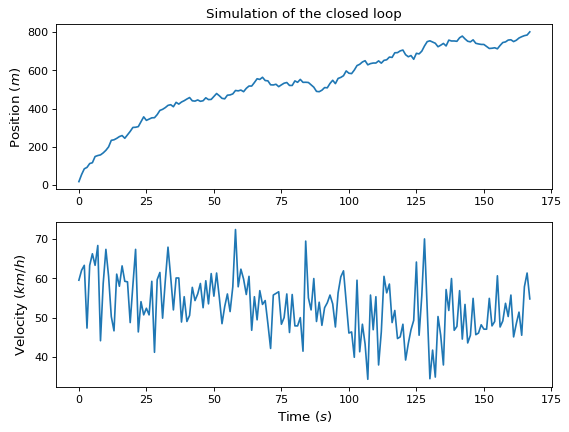

Speed: 48.36666666666667 km/h
New position: 21.547561771439188 m
Speed: 47.43333333333334 km/h
New position: 19.563831244464357 m
Speed: 60.266666666666666 km/h
New position: 40.35681820531678 m
Speed: 54.31666666666667 km/h
New position: 72.02661796830151 m
Speed: 59.56666666666667 km/h
New position: 103.15954424876006 m
Speed: 44.983333333333334 km/h
New position: 126.5577259476002 m
Speed: 54.31666666666667 km/h
New position: 142.56526182162057 m
Speed: 58.4 km/h
New position: 148.01543453453033 m
Speed: 47.43333333333334 km/h
New position: 162.29871875756598 m
Speed: 53.15 km/h
New position: 156.37384226361846 m
Speed: 64.23333333333333 km/h
New position: 177.86979304553145 m
Speed: 58.983333333333334 km/h
New position: 196.0720558303234 m
Speed: 62.833333333333336 km/h
New position: 205.2355787435723 m
Speed: 61.550000000000004 km/h
New position: 216.3899785120325 m
Speed: 56.416666666666664 km/h
New position: 221.24386163558094 m
Speed: 67.38333333333333 km/h
New position: 234.41

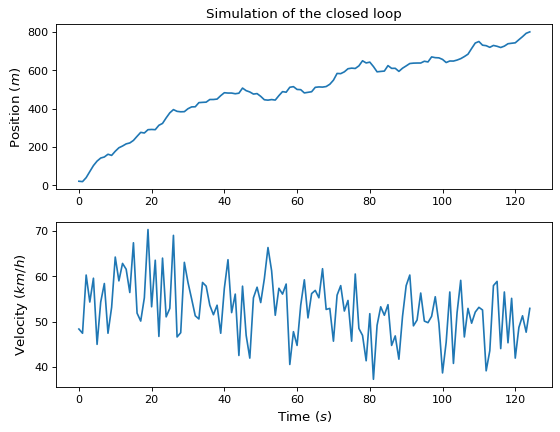

Speed: 60.800000000000004 km/h
New position: 25.416559525504567 m
Speed: 51.1 km/h
New position: 32.633158716415394 m
Speed: 63.6 km/h
New position: 47.19469792105558 m
Speed: 50.4 km/h
New position: 55.74767373192784 m
Speed: 42.1 km/h
New position: 72.8166263162463 m
Speed: 55.1 km/h
New position: 87.67610603159127 m
Speed: 51.300000000000004 km/h
New position: 102.8399773978837 m
Speed: 56.6 km/h
New position: 101.1596430523171 m
Speed: 56.1 km/h
New position: 111.80034838464226 m
Speed: 57.400000000000006 km/h
New position: 134.16182968809525 m
Speed: 55.7 km/h
New position: 139.39591413921204 m
Speed: 61.5 km/h
New position: 150.9290489819003 m
Speed: 52.5 km/h
New position: 149.8068063199187 m
Speed: 73.0 km/h
New position: 184.28505338844573 m
Speed: 63.0 km/h
New position: 177.90382255556185 m
Speed: 58.0 km/h
New position: 184.82595157568758 m
Speed: 57.7 km/h
New position: 181.56408554772838 m
Speed: 51.2 km/h
New position: 215.38051920848775 m
Speed: 59.2 km/h
New position: 

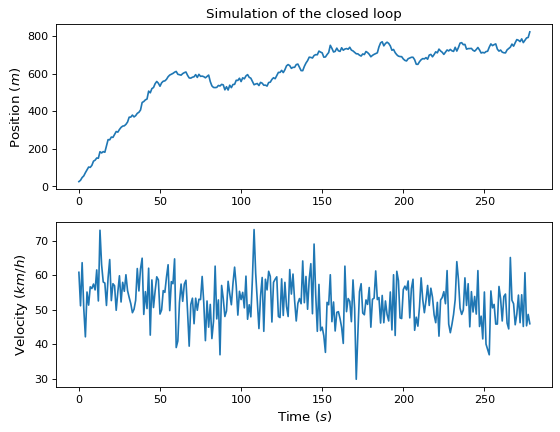

Speed: 63.7375 km/h
New position: 24.862671873003915 m
Speed: 64.35 km/h
New position: 34.139942711494406 m
Speed: 60.9375 km/h
New position: 52.54292323109881 m
Speed: 64.35 km/h
New position: 61.981957721549875 m
Speed: 53.849999999999994 km/h
New position: 87.43331783219764 m
Speed: 50.0875 km/h
New position: 108.51409774308021 m
Speed: 41.95 km/h
New position: 104.41625005462267 m
Speed: 54.9 km/h
New position: 99.73620842895927 m
Speed: 62.425 km/h
New position: 128.1580037745568 m
Speed: 60.412499999999994 km/h
New position: 141.51452998209334 m
Speed: 64.4375 km/h
New position: 147.60649487200817 m
Speed: 59.8 km/h
New position: 164.8327899438608 m
Speed: 55.3375 km/h
New position: 208.50449125484653 m
Speed: 64.69999999999999 km/h
New position: 235.28354676567665 m
Speed: 52.012499999999996 km/h
New position: 237.42855038122752 m
Speed: 61.9875 km/h
New position: 247.53553153442783 m
Speed: 54.724999999999994 km/h
New position: 260.7330816248881 m
Speed: 59.625 km/h
New positio

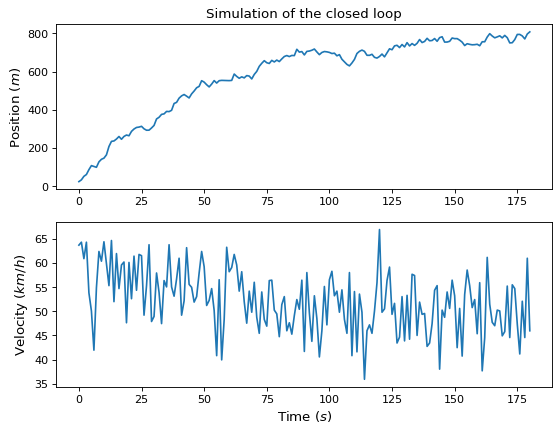

In [104]:
dict = {}

for i in range(100, 900, 100):
    v_discr = i
    d_discr = i   
    f = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_c, b_c, sigma_c, "analytic")
    g = GaussianPlant(d_max, d_min, v_max, v_min, d_discr, v_discr, a_e, b_e, sigma_e, "analytic")
    target_policy = TargetPolicy(g, fmean, fstd)

    solver = AnalyticalSolver(f, g, target_policy)
    t = time.time()
    solver.closedLoop()
    elapsed = time.time() - t
    del f
    del g
    del target_policy
    dict[i] = elapsed

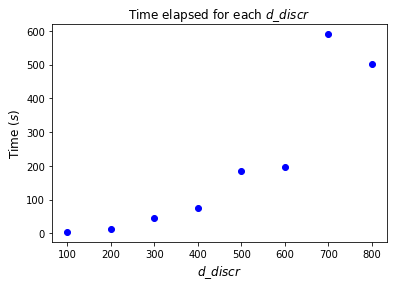

<Figure size 432x288 with 0 Axes>

In [105]:
discr = [d for d in dict.keys()]
elapsed = [t for t in dict.values()]

plt.title(r'Time elapsed for each $d\_discr$')
plt.xlabel(r'$d\_discr$', fontsize=12)
plt.ylabel(r'Time $(s)$', fontsize=12)
plt.plot(discr, elapsed, 'bo')
plt.show()
plt.savefig("elapsed")